In [ ]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torchvision import transforms
from skimage.color import rgb2lab, lab2rgb
import pandas as pd
import sys
sys.path.append('../src')
from model import MainModel
from PIL import Image
import os
import glob
from kornia.metrics import psnr
from pytorch_fid import fid_score
from torch.utils.data import DataLoader
import sys
sys.path.append('../src')
from dataset import ColorizationDataset
import cv2

import warnings
warnings.filterwarnings("ignore")

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

In [4]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet


def build_res_unet(n_input=1, n_output=2, size=256):
    body = create_body(resnet18(), pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(DEVICE)
    return net_G

In [5]:
hist_path = '../histories/Normal GAN'

train_df = pd.read_csv(f"{hist_path}/Train/normal_gan.csv")
val_df = pd.read_csv(f"{hist_path}/Val/normal_gan.csv")

train_df = train_df.groupby('epoch').mean()
val_df = val_df.groupby('epoch').mean()

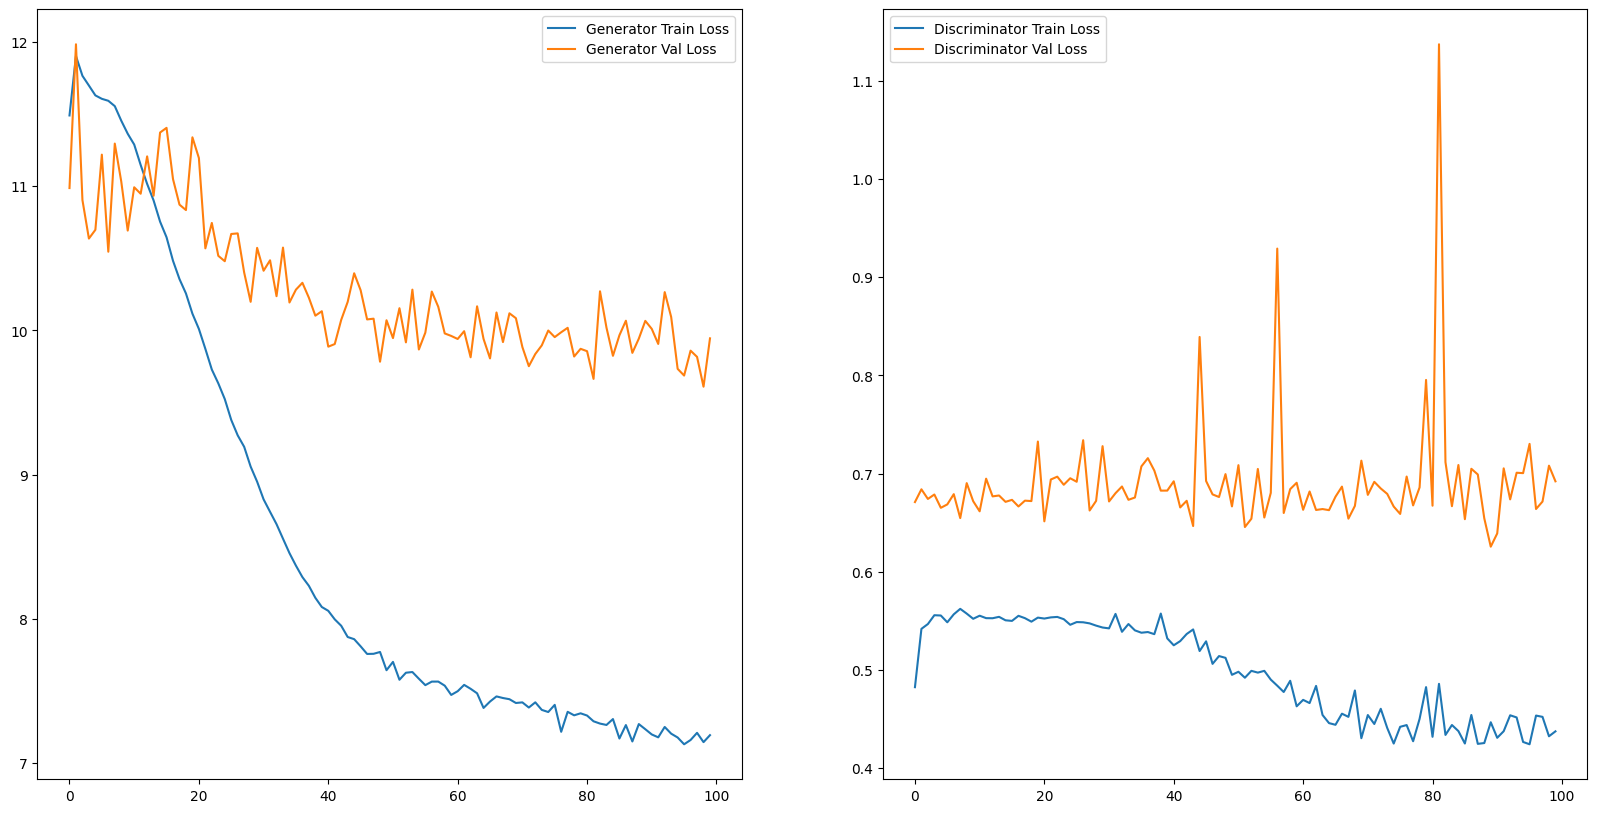

In [6]:
#plot train vs val loss of generator and discriminator side by side
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(train_df.index, train_df['loss_G'], label='Generator Train Loss')
plt.plot(val_df.index, val_df['loss_G'], label='Generator Val Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_df.index, train_df['loss_D'], label='Discriminator Train Loss')
plt.plot(val_df.index, val_df['loss_D'], label='Discriminator Val Loss')
plt.legend()
plt.show()


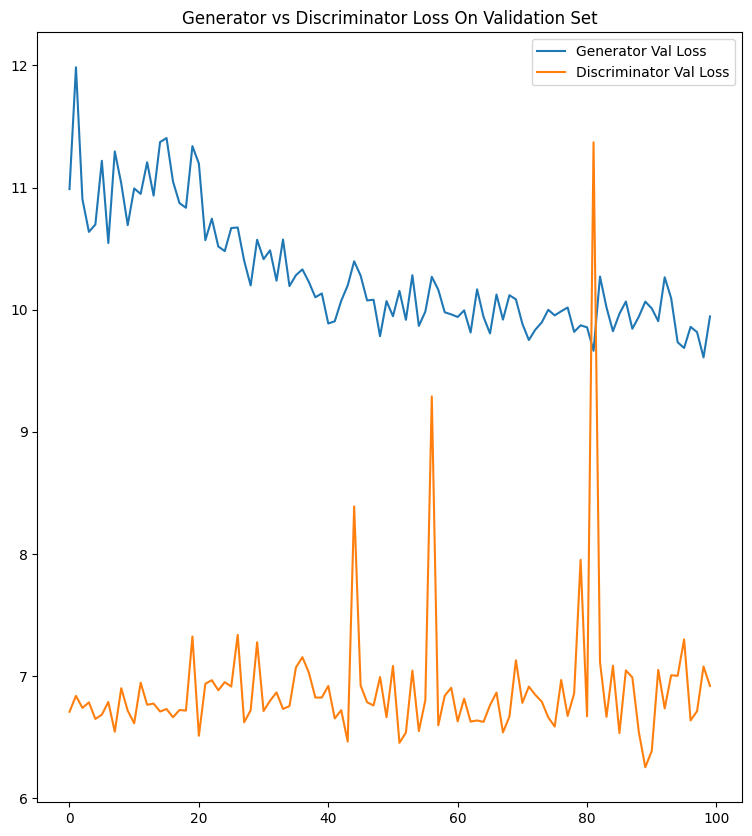

In [7]:
#plot the generator loss vs descriminator loss for each split side by side
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 2)
plt.plot(val_df.index, val_df['loss_G'], label='Generator Val Loss')
plt.plot(val_df.index, val_df['loss_D']*10, label='Discriminator Val Loss')
plt.title('Generator vs Discriminator Loss On Validation Set')
plt.legend()
plt.show()

In [17]:
hist_path = '../histories/ResNet GAN'

train_df = pd.read_csv(f"{hist_path}/Train/resnet_gan.csv")
val_df = pd.read_csv(f"{hist_path}/Val/resnet_gan.csv")

train_df = train_df.groupby('epoch').mean()
val_df = val_df.groupby('epoch').mean()

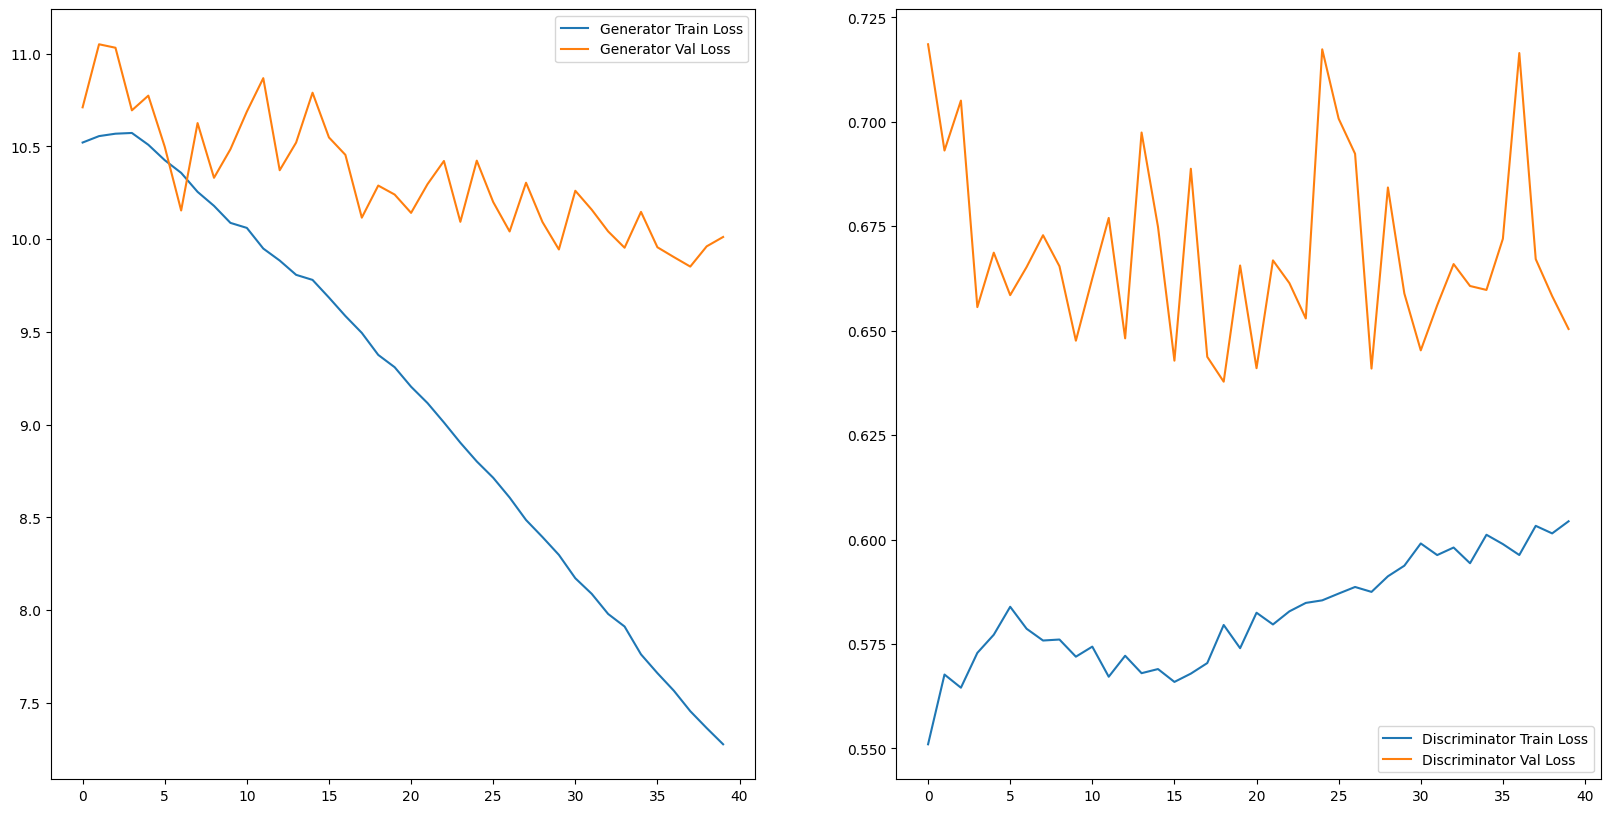

In [19]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(train_df.index, train_df['loss_G'], label='Generator Train Loss')
plt.plot(val_df.index, val_df['loss_G'], label='Generator Val Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_df.index, train_df['loss_D'], label='Discriminator Train Loss')
plt.plot(val_df.index, val_df['loss_D'], label='Discriminator Val Loss')
plt.legend()
plt.show()


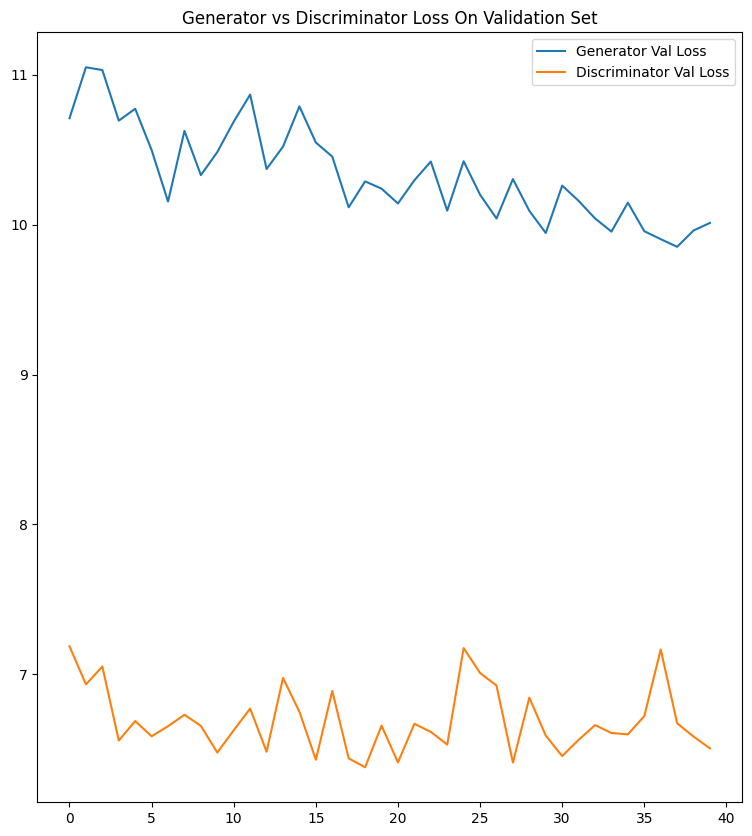

In [20]:
#plot the generator loss vs descriminator loss for each split side by side
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 2)
plt.plot(val_df.index, val_df['loss_G'], label='Generator Val Loss')
plt.plot(val_df.index, val_df['loss_D']*10, label='Discriminator Val Loss')
plt.title('Generator vs Discriminator Loss On Validation Set')
plt.legend()
plt.show()

In [6]:
folder = "D:\\AIDS\\S2\\Project\\coco-2017-dataset\\coco2017\\test2017"

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MainModel()
model.load_state_dict(
    torch.load(
        "normal_gan.pt",
        map_location=device
    )
)

model initialized with norm initialization
model initialized with norm initialization


<All keys matched successfully>

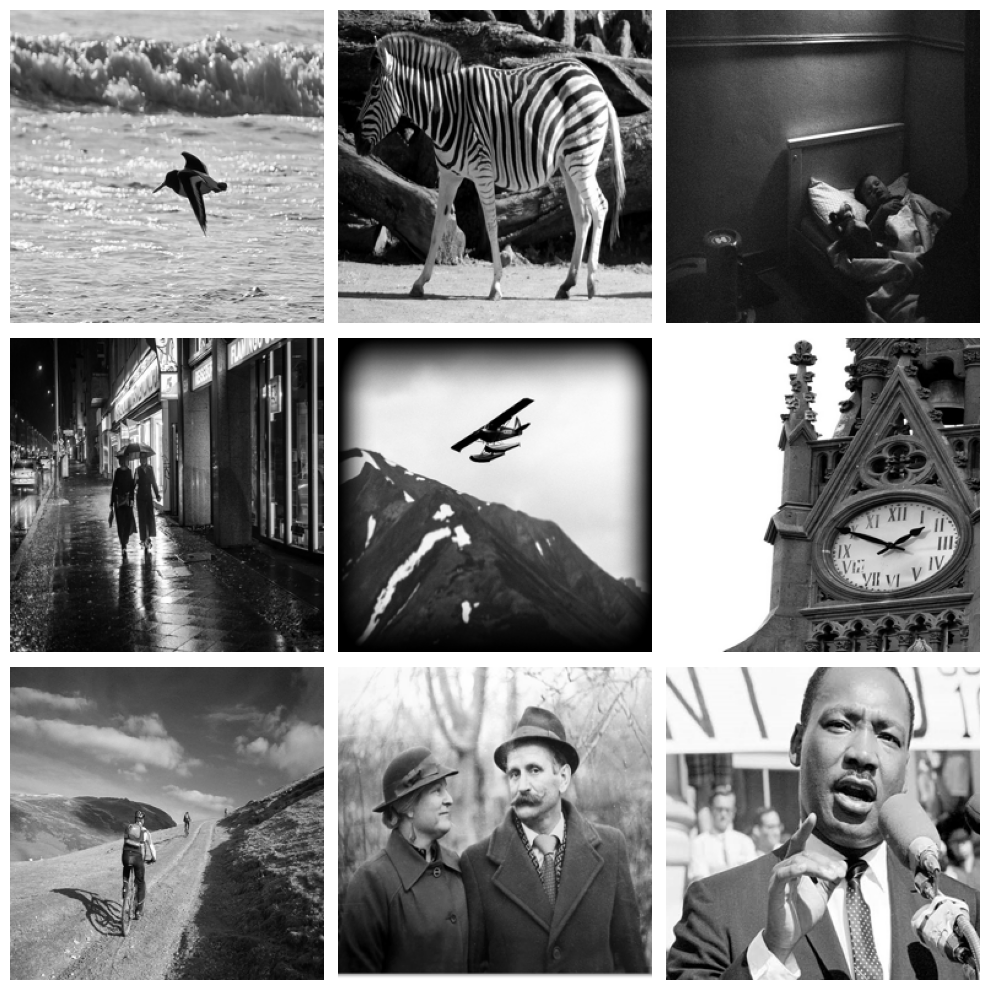

In [102]:
#random_images = random.sample(gs_images, 9)
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

#get images from folder/selected 
random_images = os.listdir(folder+'\\'+'selected')

images = []

for i, image_path in enumerate(random_images):
    img = Image.open(folder+'\\'+'selected'+'\\'+image_path)
    img = img.resize((256, 256))
    images.append(img)
    axs[i // 3, i % 3].imshow(img)
    axs[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

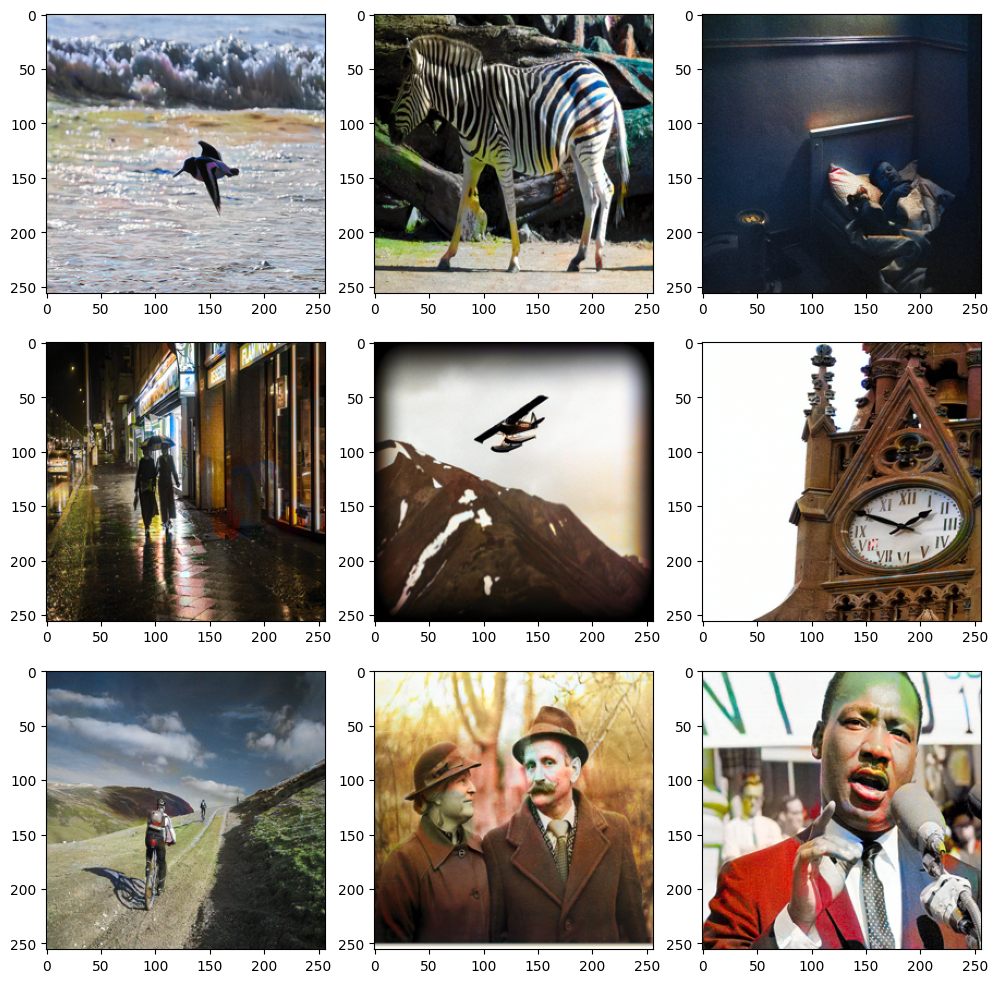

In [103]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, img in enumerate(images):
    # to make it between -1 and 1
    img = transforms.ToTensor()(img)[:1] * 2. - 1.
    model.eval()
    with torch.no_grad():
        preds = model.net_G(img.unsqueeze(0).to(DEVICE))
    colorized = lab_to_rgb(img.unsqueeze(0), preds.cpu())[0]
    row = i // 3
    col = i % 3
    axs[row, col].imshow(colorized)
    
plt.tight_layout()
plt.show()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
r_model = MainModel(net_G=net_G)
r_model.load_state_dict(
    torch.load(
        "final_model_weights.pt",
        map_location=device
    )
)

model initialized with norm initialization


<All keys matched successfully>

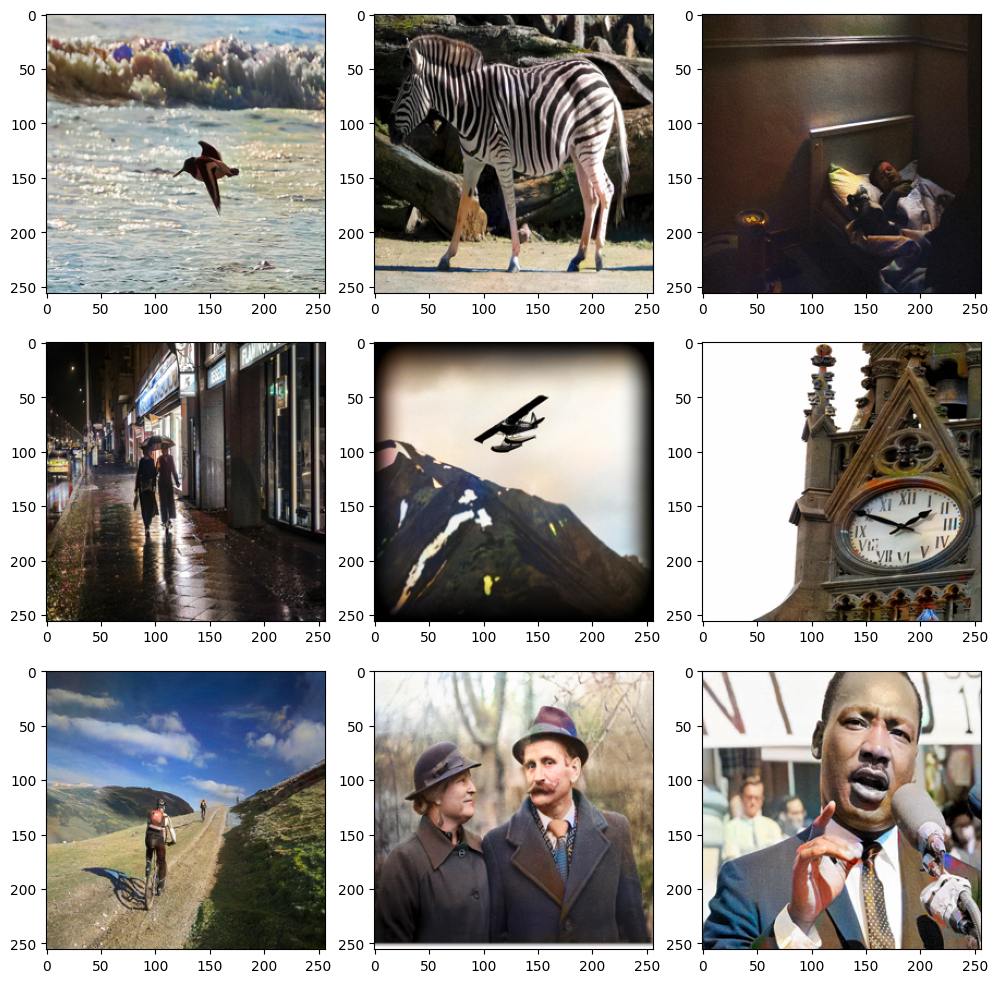

In [105]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, img in enumerate(images):
    # to make it between -1 and 1
    img = transforms.ToTensor()(img)[:1] * 2. - 1.
    model.eval()
    with torch.no_grad():
        preds = r_model.net_G(img.unsqueeze(0).to(DEVICE))
    colorized = lab_to_rgb(img.unsqueeze(0), preds.cpu())[0]
    row = i // 3
    col = i % 3
    axs[row, col].imshow(colorized)
    
plt.tight_layout()
plt.show()

In [8]:
def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, size = 256, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(size= size, **kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [11]:
paths = glob.glob(folder+"\\*.jpg")

In [9]:
test_dl = make_dataloaders(paths=paths[:1000], split='val')
data = next(iter(test_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)

NameError: name 'make_dataloaders' is not defined

In [13]:
real_images = []
generated_images = []

with torch.no_grad():
    for batch in test_dl:
        L, ab = batch['L'].to(device), batch['ab'].to(device)
        preds = model.net_G(L).to(device)
        colorized = lab_to_rgb(L, preds)
        real_images.append(torch.cat([L, ab], dim=1))
        generated_images.append(torch.from_numpy(colorized))

real_images = torch.cat(real_images, dim=0)
generated_images = torch.cat(generated_images, dim=0)

In [14]:
real_images = real_images.to(device)
generated_images = generated_images.to(device)

In [15]:
print(real_images.shape, generated_images.shape)
generated_images = generated_images.permute(0, 3, 2, 1)
print(real_images.shape, generated_images.shape)


torch.Size([1000, 3, 256, 256]) torch.Size([1000, 256, 256, 3])
torch.Size([1000, 3, 256, 256]) torch.Size([1000, 3, 256, 256])


In [16]:
def calculate_psnr(img, img2, crop_border, input_order='HWC', test_y_channel=False, **kwargs):
    assert img.shape == img2.shape, (f'Image shapes are different: {img.shape}, {img2.shape}.')
    if input_order not in ['HWC', 'CHW']:
        raise ValueError(f'Wrong input_order {input_order}. Supported input_orders are ' '"HWC" and "CHW"')
    img = img.astype(np.float64)
    img2 = img2.astype(np.float64)

    if crop_border != 0:
        img = img[crop_border:-crop_border, crop_border:-crop_border, ...]
        img2 = img2[crop_border:-crop_border, crop_border:-crop_border, ...]

    mse = np.mean((img - img2)**2)
    if mse == 0:
        return float('inf')
    return 20. * np.log10(255. / np.sqrt(mse))


def _ssim(img, img2):
    c1 = (0.01 * 255)**2
    c2 = (0.03 * 255)**2

    img = img.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + c1) * (2 * sigma12 + c2)) / ((mu1_sq + mu2_sq + c1) * (sigma1_sq + sigma2_sq + c2))
    return ssim_map.mean()


def calculate_ssim(img, img2, crop_border, input_order='HWC', test_y_channel=False, **kwargs):
    assert img.shape == img2.shape, (f'Image shapes are different: {img.shape}, {img2.shape}.')
    if input_order not in ['HWC', 'CHW']:
        raise ValueError(f'Wrong input_order {input_order}. Supported input_orders are ' '"HWC" and "CHW"')
    img = img.astype(np.float64)
    img2 = img2.astype(np.float64)

    if crop_border != 0:
        img = img[crop_border:-crop_border, crop_border:-crop_border, ...]
        img2 = img2[crop_border:-crop_border, crop_border:-crop_border, ...]

    ssims = []
    for i in range(img.shape[2]):
        ssims.append(_ssim(img[..., i], img2[..., i]))
    return np.array(ssims).mean()

def calculate_cf(img):
    R, G, B = img[0,:,:], img[1,:,:], img[2,:,:]
    rg = np.abs(R - G)
    yb = np.abs(0.5 * (R + G) - B)
    rbMean, rbStd = np.mean(rg), np.std(rg)
    ybMean, ybStd = np.mean(yb), np.std(yb)
    stdRoot = np.sqrt(rbStd ** 2 + ybStd ** 2)
    meanRoot = np.sqrt(rbMean ** 2 + ybMean ** 2)

    return stdRoot + (0.3 * meanRoot)



In [17]:
p = 0.0
s = 0.0
c = 0.0

for i in range(len(real_images)):
    real_image = real_images[i].cpu().numpy()
    generated_image = generated_images[i].cpu().numpy()
    psnr_score = calculate_psnr(real_image, generated_image, 0)
    ssim_score = calculate_ssim(real_image, generated_image, 0)
    rcf_score = calculate_cf(real_image)
    gcf_score = calculate_cf(generated_image)
    cf_loss = abs(rcf_score - gcf_score)
    p += psnr_score
    s += ssim_score
    c += cf_loss

p /= len(real_images)
s /= len(real_images)
c /= len(real_images)

print(f"PSNR: {p:.2f}, SSIM: {s:.2f}, CF: {c:.2f}")

PSNR: 52.76, SSIM: nan, CF: 0.32


In [18]:
real_images = []
generated_images = []

with torch.no_grad():
    for batch in test_dl:
        L, ab = batch['L'].to(device), batch['ab'].to(device)
        preds = r_model.net_G(L).to(device)
        colorized = lab_to_rgb(L, preds)
        real_images.append(torch.cat([L, ab], dim=1))
        generated_images.append(torch.from_numpy(colorized))
real_images = torch.cat(real_images, dim=0)
generated_images = torch.cat(generated_images, dim=0)

In [19]:
real_images = real_images.to('cpu')
generated_images = generated_images.to('cpu')

In [20]:
print(real_images.shape, generated_images.shape)
generated_images = generated_images.permute(0, 3, 2, 1)
print(real_images.shape, generated_images.shape)

torch.Size([1000, 3, 256, 256]) torch.Size([1000, 256, 256, 3])
torch.Size([1000, 3, 256, 256]) torch.Size([1000, 3, 256, 256])


In [21]:
p = 0.0
s = 0.0
c = 0.0

for i in range(len(real_images)):
    real_image = real_images[i].cpu().numpy()
    generated_image = generated_images[i].cpu().numpy()
    psnr_score = calculate_psnr(real_image, generated_image, 0)
    ssim_score = calculate_ssim(real_image, generated_image, 0)
    rcf_score = calculate_cf(real_image)
    gcf_score = calculate_cf(generated_image)
    cf_loss = abs(rcf_score - gcf_score)
    p += psnr_score
    s += ssim_score
    c += cf_loss

p /= len(real_images)
s /= len(real_images)
c /= len(real_images)

print(f"PSNR: {p:.2f}, SSIM: {s:.2f}, CF: {c:.2f}")

PSNR: 52.74, SSIM: nan, CF: 0.33
